# Kobe Bryant Shot Selection - Data Exploration

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/data.csv')

print(df.shape)

drop_list = ['combined_shot_type', 'game_event_id', 'team_id', 'game_id', 'lat', 'lon']
df = df.drop(drop_list, axis=1)
df.head()

(30697, 25)


,action_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,167,72,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,138,175,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,0,0,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [2]:
# Split the datetime into month, day, year
df['game_date'] = pd.to_datetime(df['game_date'])
df['year'] = df['game_date'].dt.year
df['month'] = df['game_date'].dt.month
df['day'] = df['game_date'].dt.day
df['secondsFromPeriodEnd'] = 60*df['minutes_remaining']+df['seconds_remaining']
df['secondsFromPeriodStart'] = 60*(11-df['minutes_remaining'])+(60-df['seconds_remaining'])
df['secondsFromGameStart'] = (df['period'] <= 4).astype(int)*(df['period']-1)*12*60 + (df['period'] > 4).astype(int)*((df['period']-4)*5*60 + 3*12*60) + df['secondsFromPeriodStart']

df = df.sort_values(['game_date'])
df.head()

,action_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,...,game_date,matchup,opponent,shot_id,year,month,day,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart
22901,Jump Shot,-140,116,0,1,0,1996-97,42,18,0.0,...,1996-11-03,LAL vs. MIN,MIN,22902,1996,11,3,42,678,678
22902,Jump Shot,-131,97,10,2,0,1996-97,8,16,0.0,...,1996-11-05,LAL @ NYK,NYK,22903,1996,11,5,608,112,832
22903,Jump Shot,-142,181,8,2,0,1996-97,37,23,1.0,...,1996-11-06,LAL @ CHH,CHA,22904,1996,11,6,517,203,923
22904,Jump Shot,0,0,6,2,0,1996-97,34,0,0.0,...,1996-11-06,LAL @ CHH,CHA,22905,1996,11,6,394,326,1046
22905,Jump Shot,-10,138,5,2,0,1996-97,27,13,1.0,...,1996-11-06,LAL @ CHH,CHA,22906,1996,11,6,327,393,1113


In [3]:
# Next, let's extract the season number 
start_year = 1996
def extract_season(dt):
    # Kobe's rookie season was 1996-1997
    # Seasons start in October, end by July of the next year
    if dt.month < 8:
        return dt.year - start_year
    else:
        return dt.year - start_year + 1
    
df['season'] = df['game_date'].apply(extract_season)
df.head()

,action_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,...,game_date,matchup,opponent,shot_id,year,month,day,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart
22901,Jump Shot,-140,116,0,1,0,1,42,18,0.0,...,1996-11-03,LAL vs. MIN,MIN,22902,1996,11,3,42,678,678
22902,Jump Shot,-131,97,10,2,0,1,8,16,0.0,...,1996-11-05,LAL @ NYK,NYK,22903,1996,11,5,608,112,832
22903,Jump Shot,-142,181,8,2,0,1,37,23,1.0,...,1996-11-06,LAL @ CHH,CHA,22904,1996,11,6,517,203,923
22904,Jump Shot,0,0,6,2,0,1,34,0,0.0,...,1996-11-06,LAL @ CHH,CHA,22905,1996,11,6,394,326,1046
22905,Jump Shot,-10,138,5,2,0,1,27,13,1.0,...,1996-11-06,LAL @ CHH,CHA,22906,1996,11,6,327,393,1113


In [4]:
# First create subset dataframes based on the season
num_seasons = 20
seasons = []

for i in range(0,num_seasons):
    seasons.append({'season_num': i+1, 'year': start_year + i})
    seasons[i]['data'] = df[df['season'] == i+1]
    
for season_num, season in enumerate(seasons):
    misses = season['data'][season['data']['shot_made_flag'] == 0.0]
    makes = season['data'][season['data']['shot_made_flag'] == 1.0]
    
    season['makes'] = makes
    season['misses'] = misses

In [5]:
# This cell is stolen from: https://www.kaggle.com/bbx396/kobe-bryant-shot-selection/kobechart

# time to add basketball court lines for context
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
%matplotlib inline 


# FG% by season

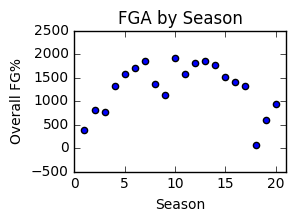

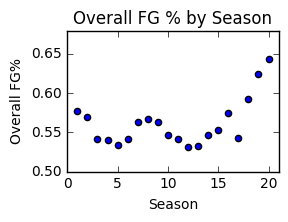

In [6]:
# First we'll look at the overall FG % by year
y_fgp = [] # field goal %
y_fga = [] # field goals attempted
x = [] # the season number
for season in seasons:
    season['num_makes'] = season['misses']['shot_made_flag'].count()
    season['num_misses'] = season['makes']['shot_made_flag'].count()
    season['FG%'] = float(season['num_makes']) / float(season['num_makes'] + season['num_misses'])
    y_fga.append(season['num_makes'] + season['num_misses'])
    y_fgp.append(season['FG%'])
    x.append(season['season_num'])

fig = plt.figure()
ax = fig.add_subplot(222)
ax.set_title('FGA by Season')
ax.set_xlabel('Season')
ax.set_ylabel('Overall FG%')
ax.set_xlim(0, 21)
ax.scatter(x,y_fga)

fig = plt.figure()
ax = fig.add_subplot(222)
ax.set_title('Overall FG % by Season')
ax.set_xlabel('Season')
ax.set_ylabel('Overall FG%')
ax.set_xlim(0, 21)
ax.scatter(x,y_fgp)

Just by observation, we can see that it almost seems like FGA and FG % have an inverse relationship...


Next up, we generate a heat map for his overall shot chart (can extend this to a season-by-season basis but that takes awhile to run)

In [9]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
output_notebook()

def draw_court(plot, color='black', lw=2, outer_lines=False):
    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = plot.circle(0, 0, radius=7.5, line_width=lw, color=color, fill_alpha=0)

    # Create backboard
    backboard = plot.rect(0, -7.5, 60, 1, line_width=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = plot.rect(0, 47.5, 160, 190, line_width=lw, color=color,fill_alpha=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = plot.rect(0, 47.5, 120, 190, line_width=lw, color=color,fill_alpha=0)

    # Create free throw top arc
    top_free_throw = plot.arc(0, 142.5, 60, 0.0, 3.125,line_width=lw, color=color)
    # Create free throw bottom arc
    bottom_free_throw = plot.arc(0, 142.5, 60, 3.125, 0,line_width=lw, color=color, line_dash=[4,4])
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = plot.arc(0, 0, 40, 0, 3.125, line_width=lw,color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = plot.rect(-220, 22.5, 1, 140, line_width=lw,color=color)
    corner_three_b = plot.rect(220, 22.5, 1, 140, line_width=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = plot.arc(0, 0, 245, 0.382, 2.743, line_width=lw,color=color)

    # Center Court
    center_outer_arc = plot.arc(0, 422.5, 60, 3.125, 0,line_width=lw, color=color)
    center_inner_arc = plot.arc(0, 422.5, 20, 3.125, 0,line_width=lw, color=color)
    
    if outer_lines:
        outer_lines = plot.rect(0, 187.5, 500, 470, line_width=lw,color=color, fill_alpha=0)

Loading BokehJS ...

In [10]:
from bokeh.models import LinearColorMapper
from bokeh.palettes import PuBu8, OrRd8
from bokeh.models import (ColumnDataSource, Plot, Circle, Range1d, LinearAxis, HoverTool, Text)

miss_source = ColumnDataSource(data=dict(
    x = seasons[0]['misses']['loc_x'],
    y = seasons[0]['misses']['loc_y'],
    alpha = [.8]*len(seasons[0]['misses']),
    seconds = seasons[0]['misses']['secondsFromPeriodEnd'],
))
make_source = ColumnDataSource(data=dict(
    x = seasons[0]['makes']['loc_x'],
    y = seasons[0]['makes']['loc_y'],
    alpha = [.8]*len(seasons[0]['makes']),
    seconds = seasons[0]['makes']['secondsFromPeriodEnd'],
))
text_source = ColumnDataSource({'year': ['1996-1997']})

#hover = HoverTool(
#        tooltips=[
#            ("Loc X: ","@x"),
#            ("Loc Y: ","@y"),
#            ("Seconds Remaining"," @seconds")
#        ]
#    )#

from ipywidgets import interact, IntSlider

from bokeh.io import show
from bokeh.plotting import figure

miss_color_mapper = LinearColorMapper(high=1000,low=3,palette=OrRd8)
make_color_mapper = LinearColorMapper(high=1000,low=3,palette=PuBu8)

# Draw the court
plot = figure(x_range=(300,-300), y_range=(-100,500))#, tools=[hover], toolbar_location=None)
#plot.set_title("Misses and Makes: Season {} ({}-{})".format(season['season_num'], season['year'], season['year']+1))
plot.circle('x','y',color={'field': 'seconds', 'transform': miss_color_mapper},source=miss_source, fill_alpha='alpha',size=6,line_alpha='alpha')
plot.circle('x', 'y',color={'field': 'seconds', 'transform': make_color_mapper},source=make_source,fill_alpha='alpha',size=6,line_alpha='alpha')
draw_court(plot, outer_lines=True)

# ### Add the background year text
# We add this first so it is below all the other glyphs
text = Text(x=290, y=-95, text='year', text_font_size='26pt', text_color='#999999')
plot.add_glyph(text_source, text)

#hist = Histogram(make_source, values='seconds', title="Auto MPG Histogram", plot_width=400)

def update(x):
    miss_source.data['x'] = seasons[x]['misses']['loc_x']
    miss_source.data['y'] = seasons[x]['misses']['loc_y']
    make_source.data['x'] = seasons[x]['makes']['loc_x']
    make_source.data['y'] = seasons[x]['makes']['loc_y']
    miss_source.data['seconds'] = seasons[x]['misses']['secondsFromPeriodEnd']
    make_source.data['seconds'] = seasons[x]['makes']['secondsFromPeriodEnd']
    #miss_source.data["alpha"] = [miss_source.data["alpha"][0]]*len(miss_source.data['x'])
    make_source.data["alpha"] = [make_source.data["alpha"][0]]*len(make_source.data['x'])
    text_source.data = {'year': [str(x+1996)+'-'+str(x+1997)]};
    push_notebook()
    
def recolor(x):
    if x == 'Combined':
        miss_source.data["alpha"] = [.8]*len(miss_source.data['x'])
        make_source.data["alpha"] = [.8]*len(make_source.data['x'])
    if x == 'Missed':
        miss_source.data["alpha"] = [.8]*len(miss_source.data['x'])
        make_source.data["alpha"] = [0]*len(make_source.data['x'])
    if x == 'Made':
        miss_source.data["alpha"] = [0]*len(miss_source.data['x'])
        make_source.data["alpha"] = [.8]*len(make_source.data['x'])
    push_notebook()
 
show(plot, notebook_handle=True)

In [11]:
interact(update, x=IntSlider(min=0,max=19,value=0))
interact(recolor, x=("Combined","Missed","Made"))

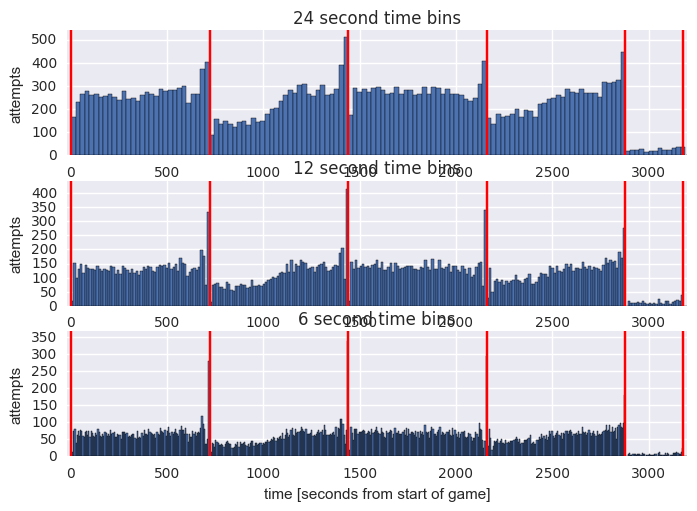

In [12]:
binsSizes = [24,12,6]

plt.figure();
for k, binSizeInSeconds in enumerate(binsSizes):
    timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
    attemptsAsFunctionOfTime, b = np.histogram(df['secondsFromGameStart'], bins=timeBins)     
    
    maxHeight = max(attemptsAsFunctionOfTime) + 30
    barWidth = 0.999*(timeBins[1]-timeBins[0])
    plt.subplot(len(binsSizes),1,k+1); 
    plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); plt.title(str(binSizeInSeconds) + ' second time bins')
    plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
    plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts')
plt.xlabel('time [seconds from start of game]')